#### Import my dataset

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


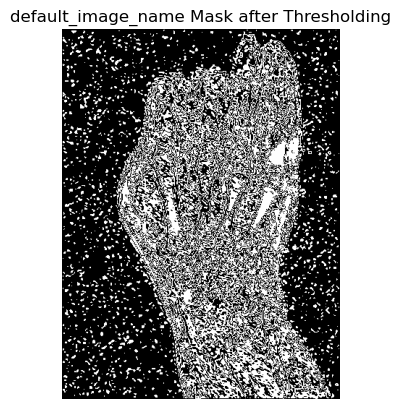

Batch image shape: torch.Size([1, 1, 16, 512, 384])
Batch label shape: torch.Size([1])


In [2]:
from pre_processing_py import HandScanDataset2, transform, validation_transform, train_df, valid_df, training_data_dir, display_images
from timm.models.layers import DropPath, trunc_normal_
import numpy as np


In [3]:
!pip install einops


In [4]:
pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


Define the swinTransformer blocks

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from einops import rearrange
from functools import reduce
from operator import mul

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x




In [6]:
class WindowAttention3D(nn.Module):
    """Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The temporal length, height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=False, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wd, Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1) * (2 * window_size[2] - 1), num_heads)
        )  # 2*Wd-1 * 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_d = torch.arange(self.window_size[0])
        coords_h = torch.arange(self.window_size[1])
        coords_w = torch.arange(self.window_size[2])
        coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))  # 3, Wd, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 3, Wd*Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 3, Wd*Wh*Ww, Wd*Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wd*Wh*Ww, Wd*Wh*Ww, 3
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 2] += self.window_size[2] - 1

        relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
        relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        relative_position_index = relative_coords.sum(-1)  # Wd*Wh*Ww, Wd*Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """Forward function.
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, N, N) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # B_, nH, N, C

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        index_clone = self.relative_position_index.clone()
        relative_position_bias = self.relative_position_bias_table[index_clone[:N, :N].reshape(-1)].reshape(
            N, N, -1
        )  # Wd*Wh*Ww,Wd*Wh*Ww,nH

        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wd*Wh*Ww, Wd*Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)  # B_, nH, N, N

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn.float() @ v.float()).transpose(1, 2).reshape(B_, N, C)
        # x = self.proj(x.half())
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

### WindowPartition and WindowReverse Functions

In [7]:
from functools import reduce
from operator import mul

def window_partition(x, window_size):
    """
    Args:
        x: (B, D, H, W, C)
        window_size (tuple[int]): window size

    Returns:
        windows: (B*num_windows, window_size*window_size, C)
    """
    print(f"This Input shape: {x.shape}")
    
    B, D, H, W, C = x.shape
    print(f"B: {B}")
    print(f"C: {C}")
    print(f"D: {D}")
    print(f"H: {H}")
    print(f"W: {W}")

    
    x = x.view(
        B,
        D // window_size[0],
        window_size[0],
        H // window_size[1],
        window_size[1],
        W // window_size[2],
        window_size[2],
        C,
    )
    
    print(f"Shape after view operation: {x.shape}")
    
    windows = x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, reduce(mul, window_size), C)
    print(f"Shape after permute and final view: {windows.shape}")
    
    return windows





In [8]:
def window_reverse(windows, window_size, B, D, H, W):
    """
    Args:
        windows: (B*num_windows, window_size[0]*window_size[1]*window_size[2], C)
        window_size (tuple[int]): Window size
        B (int): Batch size
        D (int): Depth
        H (int): Height
        W (int): Width

    Returns:
        x: (B, D, H, W, C)
    """
    # Reverse the reshape operation
    x = windows.view(B, D // window_size[0], H // window_size[1], W // window_size[2],
                     window_size[0], window_size[1], window_size[2], -1)
    x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(B, D, H, W, -1)
    print(f"Shape after reversing windows: {x.shape}")  # Debugging
    return x

### get_window_size Function
This function adjusts the window size according to the input size.

In [9]:
def get_window_size(x_size, window_size, shift_size=None):
    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            # Set the window size to the minimum of x_size[i] or 1 to avoid zero division
            use_window_size[i] = max(x_size[i], 1)
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


In [10]:
'''
def get_window_size(x_size, window_size, shift_size=None):
    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)
'''

'\ndef get_window_size(x_size, window_size, shift_size=None):\n    use_window_size = list(window_size)\n    if shift_size is not None:\n        use_shift_size = list(shift_size)\n    for i in range(len(x_size)):\n        if x_size[i] <= window_size[i]:\n            use_window_size[i] = x_size[i]\n            if shift_size is not None:\n                use_shift_size[i] = 0\n\n    if shift_size is None:\n        return tuple(use_window_size)\n    else:\n        return tuple(use_window_size), tuple(use_shift_size)\n'

### compute_mask Function
This function computes the attention mask for the shifted windows.

In [11]:
import torch

def compute_mask(D, H, W, window_size, shift_size, device):
    print(f"Dimensions (D, H, W): ({D}, {H}, {W})")
    print(f"Window size: {window_size}")
    print(f"Shift size: {shift_size}")

    img_mask = torch.zeros((1, D, H, W, 1), device=device)  # 1 Dp Hp Wp 1
    print(f"Initial img_mask shape: {img_mask.shape}")

    cnt = 0
    for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
        for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
            for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                print(f"Filling img_mask with cnt={cnt} for slices d={d}, h={h}, w={w}")
                img_mask[:, d, h, w, :] = cnt
                cnt += 1

    print(f"img_mask after filling: {img_mask.unique()}")  # Shows the unique values in the mask

    mask_windows = window_partition(img_mask, window_size)  # nW, ws[0]*ws[1]*ws[2], 1
    print(f"mask_windows shape after partitioning: {mask_windows.shape}")

    mask_windows = mask_windows.squeeze(-1)  # nW, ws[0]*ws[1]*ws[2]
    print(f"mask_windows shape after squeezing: {mask_windows.shape}")

    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    print(f"attn_mask shape after subtraction: {attn_mask.shape}")

    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    print(f"Final attn_mask shape: {attn_mask.shape}")

    return attn_mask


### PatchMerging Class
The PatchMerging class is used to downsample the spatial dimensions of the feature maps while increasing the channel dimension. 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchMerging(nn.Module):
    """ Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(8 * dim)

    def forward(self, x):
        """
        Args:
            x: Input feature, tensor size (B, D, H, W, C).
        """
        # Ensure dimensions are even before splitting
        B, D, H, W, C = x.shape
        print(f"W; {W}")
        print(f"H; {H}")
        print(f"D; {D}")
        pad_d = (D % 2 != 0)
        pad_h = (H % 2 != 0)
        pad_w = (W % 2 != 0)

        # Apply padding only if necessary
        if pad_d or pad_h or pad_w:
            x = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d))

        # Now split and concatenate as usual
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 1::2, 0::2, :]
        x5 = x[:, 1::2, 0::2, 1::2, :]
        x6 = x[:, 0::2, 1::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]

        # Check shapes after splitting
        shapes = [x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape, x7.shape]
        print(f"Shapes of tensors: {shapes}")

        # Ensure all tensors have the same shape before concatenation
        min_shape = min(x.shape[1:] for x in [x0, x1, x2, x3, x4, x5, x6, x7])

        x0 = x0[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x1 = x1[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x2 = x2[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x3 = x3[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x4 = x4[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x5 = x5[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x6 = x6[:, :min_shape[0], :min_shape[1], :min_shape[2], :]
        x7 = x7[:, :min_shape[0], :min_shape[1], :min_shape[2], :]

        # Concatenate along the last dimension
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)

        x = self.norm(x)
        print(f"Shape after normalization: {x.shape}")

        x = self.reduction(x)
        print(f"Shape after linear reduction: {x.shape}")

        return x


In [13]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchMerging(nn.Module):
    """ Patch Merging Layer.

    Args:
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(8 * dim)

    def forward(self, x):
        """
        Args:
            x: Input feature, tensor size (B, D, H, W, C).
        """
        # # print(f"Original input shape: {x.shape}")
        
        # Ensure dimensions are even before splitting
        B, D, H, W, C = x.shape
        if D % 2 != 0 or H % 2 != 0 or W % 2 != 0:
            x = F.pad(x, (0, W % 2, 0, H % 2, 0, D % 2))

        # Now split and concatenate as usual
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 1::2, 0::2, :]
        x5 = x[:, 1::2, 0::2, 1::2, :]
        x6 = x[:, 0::2, 1::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]

        # Ensure that all the tensors x0, x1, ..., x7 have the same shape
        print(f"Shapes of tensors: {[x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape, x7.shape]}")

        # Concatenate along the last dimension
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)


        x = self.norm(x)
        print(f"Shape after normalization: {x.shape}")

        x = self.reduction(x)
        print(f"Shape after linear reduction: {x.shape}")

        return x

'''

'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass PatchMerging(nn.Module):\n    """ Patch Merging Layer.\n\n    Args:\n        dim (int): Number of input channels.\n        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm\n    """\n\n    def __init__(self, dim, norm_layer=nn.LayerNorm):\n        super().__init__()\n        self.dim = dim\n        self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)\n        self.norm = norm_layer(8 * dim)\n\n    def forward(self, x):\n        """\n        Args:\n            x: Input feature, tensor size (B, D, H, W, C).\n        """\n        # # print(f"Original input shape: {x.shape}")\n        \n        # Ensure dimensions are even before splitting\n        B, D, H, W, C = x.shape\n        if D % 2 != 0 or H % 2 != 0 or W % 2 != 0:\n            x = F.pad(x, (0, W % 2, 0, H % 2, 0, D % 2))\n\n        # Now split and concatenate as usual\n        x0 = x[:, 0::2, 0::2, 0::2, :]\n        x1 


#### Build the Transformer Layers and Network

In [14]:
class SwinTransformerBlock3D(nn.Module):
    """Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (tuple[int]): Window size.
        shift_size (tuple[int]): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(
        self,
        dim,
        num_heads,
        window_size=(2, 7, 7),
        shift_size=(0, 0, 0),
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
        use_checkpoint=False,
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint

        assert 0 <= self.shift_size[0] < self.window_size[0], "shift_size must in 0-window_size"
        assert 0 <= self.shift_size[1] < self.window_size[1], "shift_size must in 0-window_size"
        assert 0 <= self.shift_size[2] < self.window_size[2], "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention3D(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward_part1(self, x, mask_matrix):
        B, D, H, W, C = x.shape
        window_size, shift_size = get_window_size((D, H, W), self.window_size, self.shift_size)
        x = self.norm1(x)
        pad_l = pad_t = pad_d0 = 0
        pad_d1 = (window_size[0] - D % window_size[0]) % window_size[0]
        pad_b = (window_size[1] - H % window_size[1]) % window_size[1]
        pad_r = (window_size[2] - W % window_size[2]) % window_size[2]
        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
        _, Dp, Hp, Wp, _ = x.shape
        # cyclic shift
        if any(i > 0 for i in shift_size):
            shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        # partition windows
        x_windows = window_partition(shifted_x, window_size)  # B*nW, Wd*Wh*Ww, C
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # B*nW, Wd*Wh*Ww, C
        # merge windows
        attn_windows = attn_windows.view(-1, *(window_size + (C,)))
        shifted_x = window_reverse(attn_windows, window_size, B, Dp, Hp, Wp)  # B D' H' W' C
        # reverse cyclic shift
        if any(i > 0 for i in shift_size):
            x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
        else:
            x = shifted_x

        if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
            x = x[:, :D, :H, :W, :].contiguous()
        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def forward(self, x, mask_matrix):
        """Forward function.

        Args:
            x: Input feature, tensor size (B, D, H, W, C).
            mask_matrix: Attention mask for cyclic shift.
        """

        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)

        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x)
        else:
            x = x + self.forward_part2(x)

        return x

In [15]:
def compute_mask(D, H, W, window_size, shift_size, device):
    img_mask = torch.zeros((1, D, H, W, 1), device=device)  # 1 Dp Hp Wp 1
    cnt = 0
    for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
        for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
            for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                img_mask[:, d, h, w, :] = cnt
                cnt += 1
    # pdb.set_trace()
    mask_windows = window_partition(img_mask, window_size)  # nW, ws[0]*ws[1]*ws[2], 1
    mask_windows = mask_windows.squeeze(-1)  # nW, ws[0]*ws[1]*ws[2]
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    return attn_mask


### BasicLayer Class
The BasicLayer class handles the core operations in the Swin Transformer for each stage.

In [16]:
class BasicLayer(nn.Module):
    """A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of feature channels
        depth (int): Depths of this stage.
        num_heads (int): Number of attention head.
        window_size (tuple[int]): Local window size. Default: (1,7,7).
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
    """

    def __init__(
        self,
        dim,
        depth,
        num_heads,
        window_size=(7, 7, 7),
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock3D(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=(0, 0, 0) if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer
                )
                for i in range(depth)
            ]
        )

        self.downsample = downsample
        if self.downsample is not None:
            self.downsample = downsample(dim=dim, norm_layer=norm_layer)

    def forward(self, x):
        """Forward function.

        Args:
            x: Input feature, tensor size (B, C, D, H, W).
        """
        # calculate attention mask for SW-MSA

        B, C, D, H, W = x.shape
        window_size, shift_size = get_window_size((D, H, W), self.window_size, self.shift_size)
        x = rearrange(x, "b c d h w -> b d h w c")
        Dp = int(np.ceil(D / window_size[0])) * window_size[0]
        Hp = int(np.ceil(H / window_size[1])) * window_size[1]
        Wp = int(np.ceil(W / window_size[2])) * window_size[2]
        attn_mask = compute_mask(Dp, Hp, Wp, window_size, shift_size, x.device)
        for blk in self.blocks:
            # pdb.set_trace()
            x = blk(x, attn_mask)
        x = x.view(B, D, H, W, -1)

        if self.downsample is not None:
            x = self.downsample(x)
        x = rearrange(x, "b d h w c -> b c d h w")
        return x

In [17]:
import torch.nn as nn
from monai.networks.blocks import UnetBasicBlock

class PatchEmbed3D(nn.Module):
    """Video to Patch Embedding.

    Args:
        patch_size (int): Patch token size. Default: (2,4,4).
        in_chans (int): Number of input video channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, patch_size=(4, 4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        self.patch_size = patch_size

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = UnetBasicBlock(
            spatial_dims=3,
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=3,
            stride=2,
            norm_name=("INSTANCE", {"affine": True}),
        )
        # self.proj = nn.Conv3d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """Forward function."""
        x = self.proj(x)  # B C D Wh Ww
        return x


### Combine Layers into the FullSwin Transformer 3D model. Integrate these Swin Transformer blocks into a model that can process 3D medical images from your dataset.

In [23]:
class SwinTransformer3D(nn.Module):
    def __init__(
        self,
        img_size=(20, 512, 512),
        patch_size=(2, 4, 4),
        in_chans=1,
        num_classes=2,
        embed_dim=512,
        depths=[2, 2, 6, 2],
        num_heads=[1, 2, 4, 8],  # Adjusted to match embed_dim
        window_size=(2, 16, 16),    # Adjusted to better fit the image size
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        norm_layer=nn.LayerNorm,
        patch_norm=False,
        use_checkpoint=False,
    ):
        super().__init__()
        self.window_size = window_size
        self.patch_embed = PatchEmbed3D(
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if patch_norm else None,
        )

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.layers = nn.ModuleList()
        for i_layer in range(len(depths)):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if i_layer < len(depths) - 1 else None,
                use_checkpoint=use_checkpoint,
            )
            self.layers.append(layer)
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.norm = nn.LayerNorm()
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(int(embed_dim * 2 ** (len(depths) - 1)), num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        _, _, D, H, W = x.size()
        x = self.patch_embed(x)
        print(f"Number of features per patch after embedding: {x.shape[-1]}") 
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)
        print(f"Shape before reshape{x.shape}")
        x = x.reshape(-1, (D // 8) * (H // 8) * (W // 8), 2 * self.num_features)
        print(f"Shape before norm{x.shape}")
        x = self.norm(x)
        print(f"Shape before avg pool{x.shape}")
        x = self.avgpool(x.transpose(1, 2))
        print(f"Shape before flatten{x.shape}")
        x = torch.flatten(x, 1)
        print(f"Shape before head{x.shape}")
        x = self.head(x)
        return x


In [25]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.activation_count = 0

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.activation_count += 1
                return True
        return False

# Instantiate EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

#### Train my model

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
import torch.nn.functional as F
import psutil  # For memory tracking
import gc


# Define the output directory and log directory
output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Parameters
num_epochs = 1
batch_size = 1
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alpha = 0.05  # scaling factor for LCMCL loss

# Select a few subjects (e.g., the first three subjects)
train_subset_df = train_df.iloc[:1]
# Initialize the dataset with the selected subjects
test_dataset = HandScanDataset2(labels_df=train_subset_df, data_dir=training_data_dir, transform=None)
# Create a data loader for testing
train_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Select a few subjects (e.g., the first three subjects)
valid_subset_df = valid_df.iloc[:1]
# Initialize the dataset with the selected subjects
train_dataset = HandScanDataset2(labels_df=valid_subset_df, data_dir=training_data_dir, transform=None)
# Create a data loader for testing
valid_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

'''
# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = HandScanDataset2(labels_df=valid_df, data_dir=training_data_dir, transform=validation_transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
'''

# Initialize model, optimizer, and loss function
model = SwinTransformer3D(
    img_size=(16, 512, 384),  # Adjust according to your input size
    patch_size=(2, 4, 4),     # Adjusted patch size
    in_chans=1,               # Number of input channels
    num_classes=2,            # Number of classes for classification
    embed_dim=128,            # Embedding dimension
    depths=[2, 2, 2, 2],      # Depths per stage
    num_heads=[4, 8, 16, 32],# Number of attention heads per stage
    window_size=(2, 16, 16),  # Window size matching model config
    mlp_ratio=2.0,            # MLP ratio
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.0,
    norm_layer=nn.LayerNorm,
    patch_norm=False,
    use_checkpoint=False
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion_L1 = nn.L1Loss()

# Debugging: Print model summary
print(f"Model Summary:\n{model}")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Memory and CPU tracking before training
print(f"Initial Memory Usage: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")
print(f"Initial CPU Usage: {psutil.cpu_percent()}%")


# Contrastive Loss Function
def contrastive_loss(zsim, zlabel, alpha=0.05):
    # Binary cross-entropy loss on the similarity matrix
    bce_loss = nn.BCEWithLogitsLoss()
    return alpha * bce_loss(zsim, zlabel)

# Instantiate EarlyStopper
early_stopper = EarlyStopper()

# Training and Validation loop
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    total_train_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Debugging: Track memory before forward pass
            print(f"Before Forward Pass: Memory Usage: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")
            
            if torch.any(torch.tensor(images.shape) == 0):
                raise ValueError(f"Input tensor has zero-sized dimension: {images.shape}")

            # Forward pass
            outputs = model(images)
            
            # Calculate L1 loss
            loss_L1 = criterion_L1(outputs, images)
            # Debugging: Track memory after forward pass
            print(f"After Forward Pass: Memory Usage: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

            
            # Calculate similarity matrix and contrastive loss (LCMCL)
            zsim = torch.matmul(outputs, outputs.T) * torch.exp(0.07)
            zlabel = torch.eye(zsim.size(0), device=device)
            loss_CMCL = contrastive_loss(zsim, zlabel, alpha=alpha)
            
            # Total loss
            loss = loss_L1 + loss_CMCL
            loss.backward()
            # Debugging: Track memory after backward pass
            print(f"After Backward Pass: Memory Usage: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

            optimizer.step()

            total_train_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Logging every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    # Log average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')
    
    # Manually trigger garbage collection
    gc.collect()  
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            
            # Calculate L1 loss
            loss_L1 = criterion_L1(outputs, images)
            
            # Calculate similarity matrix and contrastive loss (LCMCL)
            zsim = torch.matmul(outputs, outputs.T) * torch.exp(0.07)
            zlabel = torch.eye(zsim.size(0), device=device)
            loss_CMCL = contrastive_loss(zsim, zlabel, alpha=alpha)
            
            # Total loss
            loss = loss_L1 + loss_CMCL

            total_val_loss += loss.item()
    
    # Log average validation loss for the epoch
    avg_val_loss = total_val_loss / len(valid_loader)
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

    # Time taken for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    logger.info(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds')

     # Early stopping check
    if early_stopper.early_stop(avg_val_loss):
        # Save model parameters if early stopping criteria are met for the first time
        if early_stopper.activation_count == 1:
            logger.info(f"\nEarly stopping criteria reached!\nSaving model parameters to {output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth\n")
            # Save network parameters and losses
            opt_model_filepath = f"{output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth"
            Early_Stop_Epoch = epoch + 1
            torch.save(model.state_dict(), opt_model_filepath)

    # Switch back to training mode
    model.train()

# Manually trigger garbage collection
gc.collect()   

# Closing the writer at the end
writer.close()


Model Summary:
SwinTransformer3D(
  (patch_embed): PatchEmbed3D(
    (proj): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(1, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (norm2): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0-1): 2 x SwinTransformerBlock3D(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention3D(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (at

Epoch 1/1:   0%|          | 0/1 [00:00<?, ?batch/s]

Before Forward Pass: Memory Usage: 4.63 GB
This Input shape: torch.Size([1, 8, 256, 192, 1])
B: 1
C: 1
D: 8
H: 256
W: 192
Shape after view operation: torch.Size([1, 4, 2, 16, 16, 12, 16, 1])
Shape after permute and final view: torch.Size([768, 512, 1])
This Input shape: torch.Size([1, 8, 256, 192, 128])
B: 1
C: 128
D: 8
H: 256
W: 192
Shape after view operation: torch.Size([1, 4, 2, 16, 16, 12, 16, 128])
Shape after permute and final view: torch.Size([768, 512, 128])
Shape after reversing windows: torch.Size([1, 8, 256, 192, 128])
This Input shape: torch.Size([1, 8, 256, 192, 128])
B: 1
C: 128
D: 8
H: 256
W: 192
Shape after view operation: torch.Size([1, 4, 2, 16, 16, 12, 16, 128])
Shape after permute and final view: torch.Size([768, 512, 128])
Shape after reversing windows: torch.Size([1, 8, 256, 192, 128])
W; 192
H; 256
D; 8
Shapes of tensors: [torch.Size([1, 4, 128, 96, 128]), torch.Size([1, 4, 128, 96, 128]), torch.Size([1, 4, 128, 96, 128]), torch.Size([1, 4, 128, 96, 128]), torch.

Epoch 1/1:   0%|          | 0/1 [00:42<?, ?batch/s]


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast  # Import for mixed precision training

# Define the output directory and log directory
output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Parameters
num_epochs = 10
batch_size = 1
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize validation dataset and data loader
valid_dataset = HandScanDataset2(labels_df=valid_df, data_dir=training_data_dir, transform=validation_transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


# Initialize model, optimizer, and loss function
model = SwinTransformer3D(
    img_size=(4, 512, 512),   # Updated input size to match the new depth
    patch_size=(1, 4, 4),     # Adjusted patch size for the new depth
    in_chans=1,               # Number of input channels
    num_classes=2,            # Number of classes for classification
    embed_dim=512,            # Embedding dimension
    depths=[2, 2, 4, 2],      # Adjusted depths per stage
    num_heads=[8, 16, 32, 64],# Number of attention heads per stage
    window_size=(1, 16, 16),  # Adjusted window size to match the new depth
    mlp_ratio=4.0,            # MLP ratio
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.2,
    norm_layer=nn.LayerNorm,
    patch_norm=False,
    use_checkpoint=False
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Training loop
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, images)

            # Backward pass and optimization with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Logging every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    # Log average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            total_val_loss += loss.item()
    
    # Log average validation loss for the epoch
    avg_val_loss = total_val_loss / len(valid_loader)
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

    # Time taken for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    logger.info(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds')

     # Early stopping check
    if early_stopper.early_stop(avg_val_loss):
        # Save model parameters if early stopping criteria are met for the first time
        if early_stopper.activation_count == 1:
            logger.info(f"\nEarly stopping criteria reached!\nSaving model parameters to {output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth\n")
            # Save network parameters and losses
            opt_model_filepath = f"{output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth"
            Early_Stop_Epoch = epoch + 1
            torch.save(model.state_dict(), opt_model_filepath)
        

    # Switch back to training mode
    model.train()

# Closing the writer at the end
writer.close()


/Users/eleanorbolton/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/eleanorbolton/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/10:   0%|          | 0/172 [00:00<?, ?batch/s]/Users/eleanorbolton/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


This Input shape: torch.Size([1, 10, 256, 256, 1])
B: 1
C: 1
D: 10
H: 256
W: 256
Shape after view operation: torch.Size([1, 10, 1, 16, 16, 16, 16, 1])
Shape after permute and final view: torch.Size([2560, 256, 1])
This Input shape: torch.Size([1, 10, 256, 256, 512])
B: 1
C: 512
D: 10
H: 256
W: 256
Shape after view operation: torch.Size([1, 10, 1, 16, 16, 16, 16, 512])
Shape after permute and final view: torch.Size([2560, 256, 512])
Shape after reversing windows: torch.Size([1, 10, 256, 256, 512])
This Input shape: torch.Size([1, 10, 256, 256, 512])
B: 1
C: 512
D: 10
H: 256
W: 256
Shape after view operation: torch.Size([1, 10, 1, 16, 16, 16, 16, 512])
Shape after permute and final view: torch.Size([2560, 256, 512])


: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time

# Define the output directory and log directory
output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Parameters
num_epochs = 10
batch_size = 1
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, and loss function
model = SwinTransformer3D(
    img_size=(20, 512, 512),  # Adjust according to your input size
    patch_size=(2, 4, 4),     # Adjusted patch size
    in_chans=1,               # Number of input channels
    num_classes=2,            # Number of classes for classification
    embed_dim=512,            # Embedding dimension
    depths=[2, 2, 6, 2],      # Depths per stage
    num_heads=[8, 16, 32, 64],# Number of attention heads per stage
    window_size=(2, 16, 16),  # Window size matching model config
    mlp_ratio=4.0,            # MLP ratio
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.2,
    norm_layer=nn.LayerNorm,
    patch_norm=False,
    use_checkpoint=False
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)  # Remove attn_mask from here, as it's handled internally
            loss = criterion(outputs, images)  # Assuming you have labels, use them instead of images
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Logging every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    # Log average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Time taken for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    logger.info(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds')

# Closing the writer at the end
writer.close()


Epoch 1/10:   0%|          | 0/43 [00:00<?, ?batch/s]

: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time

# Define the output directory and log directory
output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Parameters
num_epochs = 10
batch_size = 1
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=train_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = HandScanDataset2(labels_df=valid_df, data_dir=training_data_dir, transform=validation_transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = SwinTransformer3D(
    img_size=(20, 512, 512),  # Adjust according to your input size
    patch_size=(2, 4, 4),     # Adjusted patch size
    in_chans=1,               # Number of input channels
    num_classes=2,            # Number of classes for classification
    embed_dim=512,            # Embedding dimension
    depths=[2, 2, 6, 2],      # Depths per stage
    num_heads=[8, 16, 32, 64],# Number of attention heads per stage
    window_size=(2, 16, 16),  # Window size matching model config
    mlp_ratio=4.0,            # MLP ratio
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.2,
    norm_layer=nn.LayerNorm,
    patch_norm=False,
    use_checkpoint=False
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training and Validation loop
model.train()
for epoch in range(num_epochs):
    start_time = time.time()
    total_train_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, (images, _) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)  # Compare the output to the original images (for reconstruction)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # Update progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Logging every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
    # Log average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (images, _) in enumerate(valid_loader):
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)  # Compare the output to the original images (for reconstruction)

            total_val_loss += loss.item()
    
    # Log average validation loss for the epoch
    avg_val_loss = total_val_loss / len(valid_loader)
    writer.add_scalar('Loss/validation', avg_val_loss, epoch)
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

    # Time taken for the epoch
    end_time = time.time()
    epoch_time = end_time - start_time
    logger.info(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds')

     # Early stopping check
    if early_stopper.early_stop(avg_val_loss):
        # Save model parameters if early stopping criteria are met for the first time
        if early_stopper.activation_count == 1:
            logger.info(f"\nEarly stopping criteria reached!\nSaving model parameters to {output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth\n")
            # Save network parameters and losses
            opt_model_filepath = f"{output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth"
            Early_Stop_Epoch = epoch + 1
            torch.save(model.state_dict(), opt_model_filepath)
        
        # Switch back to training mode
    model.train()
    
# Closing the writer at the end
writer.close()



In [ ]:
import matplotlib.pyplot as plt

def show_images(inputs, outputs, n=4):
    """
    Function to visualize input and output images side by side.

    Parameters:
    - inputs (Tensor): The input images tensor of shape (B, C, D, H, W).
    - outputs (Tensor): The output images tensor of shape (B, C, D, H, W).
    - n (int): Number of images to display.
    """
    inputs = inputs.cpu().detach()
    outputs = outputs.cpu().detach()

    fig, axes = plt.subplots(n, 2, figsize=(10, n*5))
    
    for i in range(n):
        # Display the input image (choose the middle slice for visualization)
        axes[i, 0].imshow(inputs[i, 0, inputs.shape[2]//2], cmap='gray')
        axes[i, 0].set_title(f'Input Image {i+1}')
        axes[i, 0].axis('off')

        # Display the output image (choose the middle slice for visualization)
        axes[i, 1].imshow(outputs[i, 0, outputs.shape[2]//2], cmap='gray')
        axes[i, 1].set_title(f'Output Image {i+1}')
        axes[i, 1].axis('off')
    
    plt.show()

# Get a batch of data
images, labels = next(iter(train_loader))
images = images.to(device)

# Compute mask matrix
attn_mask = compute_mask(
    D=images.shape[2], 
    H=images.shape[3], 
    W=images.shape[4], 
    window_size=model.window_size, 
    shift_size=model.shift_size, 
    device=images.device
)

# Forward pass through the model
with torch.no_grad():
    outputs = model(images, attn_mask)

# Visualize the input and output images
show_images(images, outputs, n=4)


NameError: name 'model' is not defined